In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
def create_mvit_model(architecture='mvitv2_tiny', num_classes=4, pretrained=True):
    """Create MViT v2 (Multiscale Vision Transformer) model for multi-class classification"""
    if architecture == 'mvitv2_tiny':
        model = timm.create_model('mvitv2_tiny', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'mvitv2_small':
        model = timm.create_model('mvitv2_small', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'mvitv2_base':
        model = timm.create_model('mvitv2_base', pretrained=pretrained, num_classes=num_classes)
    else:
        raise ValueError("Architecture must be 'mvitv2_tiny', 'mvitv2_small', or 'mvitv2_base'")
    
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train MViT v2 Tiny

Training MViT v2 Tiny (without Imaging Type)


model.safetensors:   0%|          | 0.00/96.7M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:15<00:00,  2.49it/s, Loss=1.3142, Acc=0.3643]


Train Loss: 1.3142 Acc: 0.3643 Macro-F1: 0.3382


Val : 100%|██████████| 10/10 [00:01<00:00,  5.84it/s, Loss=1.0572, Acc=0.5625]


Val Loss: 1.0572 Acc: 0.5625 Macro-F1: 0.4239
✓ New best model saved with validation macro-F1: 0.4239

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=0.9807, Acc=0.5535]


Train Loss: 0.9807 Acc: 0.5535 Macro-F1: 0.5006


Val : 100%|██████████| 10/10 [00:01<00:00,  6.61it/s, Loss=0.7841, Acc=0.7007]


Val Loss: 0.7841 Acc: 0.7007 Macro-F1: 0.6322
✓ New best model saved with validation macro-F1: 0.6322

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=0.8315, Acc=0.6661]


Train Loss: 0.8315 Acc: 0.6661 Macro-F1: 0.6080


Val : 100%|██████████| 10/10 [00:01<00:00,  6.56it/s, Loss=0.8651, Acc=0.6941]


Val Loss: 0.8651 Acc: 0.6941 Macro-F1: 0.6298

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=0.8193, Acc=0.6785]


Train Loss: 0.8193 Acc: 0.6785 Macro-F1: 0.6297


Val : 100%|██████████| 10/10 [00:01<00:00,  6.52it/s, Loss=0.7542, Acc=0.7171]


Val Loss: 0.7542 Acc: 0.7171 Macro-F1: 0.6638
✓ New best model saved with validation macro-F1: 0.6638

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=0.6651, Acc=0.7681]


Train Loss: 0.6651 Acc: 0.7681 Macro-F1: 0.7188


Val : 100%|██████████| 10/10 [00:01<00:00,  6.56it/s, Loss=0.8837, Acc=0.7072]


Val Loss: 0.8837 Acc: 0.7072 Macro-F1: 0.6485

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=0.3610, Acc=0.8865]


Train Loss: 0.3610 Acc: 0.8865 Macro-F1: 0.8574


Val : 100%|██████████| 10/10 [00:01<00:00,  6.62it/s, Loss=0.3243, Acc=0.9013]


Val Loss: 0.3243 Acc: 0.9013 Macro-F1: 0.8681
✓ New best model saved with validation macro-F1: 0.8681

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:14<00:00,  2.70it/s, Loss=0.2833, Acc=0.9071]


Train Loss: 0.2833 Acc: 0.9071 Macro-F1: 0.8832


Val : 100%|██████████| 10/10 [00:01<00:00,  6.58it/s, Loss=0.4021, Acc=0.8684]


Val Loss: 0.4021 Acc: 0.8684 Macro-F1: 0.8598

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=0.1363, Acc=0.9515]


Train Loss: 0.1363 Acc: 0.9515 Macro-F1: 0.9489


Val : 100%|██████████| 10/10 [00:01<00:00,  6.48it/s, Loss=0.0927, Acc=0.9704]


Val Loss: 0.0927 Acc: 0.9704 Macro-F1: 0.9684
✓ New best model saved with validation macro-F1: 0.9684

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=0.0350, Acc=0.9942]


Train Loss: 0.0350 Acc: 0.9942 Macro-F1: 0.9942


Val : 100%|██████████| 10/10 [00:01<00:00,  6.55it/s, Loss=0.0655, Acc=0.9770]


Val Loss: 0.0655 Acc: 0.9770 Macro-F1: 0.9724
✓ New best model saved with validation macro-F1: 0.9724

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=0.0179, Acc=0.9984]


Train Loss: 0.0179 Acc: 0.9984 Macro-F1: 0.9985


Val : 100%|██████████| 10/10 [00:01<00:00,  6.47it/s, Loss=0.0589, Acc=0.9868]


Val Loss: 0.0589 Acc: 0.9868 Macro-F1: 0.9897
✓ New best model saved with validation macro-F1: 0.9897

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=0.0088, Acc=0.9992]


Train Loss: 0.0088 Acc: 0.9992 Macro-F1: 0.9994


Val : 100%|██████████| 10/10 [00:01<00:00,  6.61it/s, Loss=0.0595, Acc=0.9836]


Val Loss: 0.0595 Acc: 0.9836 Macro-F1: 0.9867

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=0.0042, Acc=1.0000]


Train Loss: 0.0042 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  6.53it/s, Loss=0.0614, Acc=0.9868]


Val Loss: 0.0614 Acc: 0.9868 Macro-F1: 0.9897

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=0.0028, Acc=1.0000]


Train Loss: 0.0028 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  6.47it/s, Loss=0.0619, Acc=0.9868]


Val Loss: 0.0619 Acc: 0.9868 Macro-F1: 0.9897

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=0.0018, Acc=1.0000]


Train Loss: 0.0018 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  6.64it/s, Loss=0.0638, Acc=0.9836]


Val Loss: 0.0638 Acc: 0.9836 Macro-F1: 0.9871

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=0.0015, Acc=1.0000]


Train Loss: 0.0015 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  6.45it/s, Loss=0.0638, Acc=0.9836]


Val Loss: 0.0638 Acc: 0.9836 Macro-F1: 0.9871
Early stopping triggered after 15 epochs
Training complete in 3m 56s
Best validation macro-F1: 0.9897


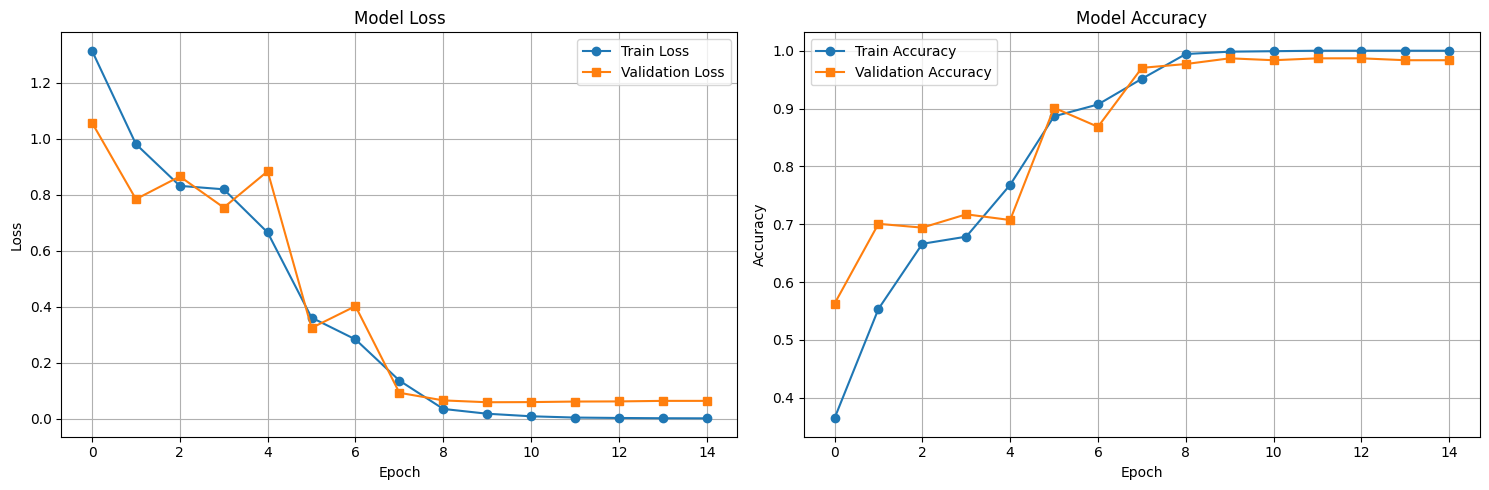

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.03it/s]


Test Accuracy: 37.57%
Test Loss: 2.4522

Classification Report:
              precision    recall  f1-score   support

         HGC       0.47      0.51      0.49        74
         LGC       0.39      0.34      0.36        53
         NST       0.35      0.22      0.27        37
         NTL       0.18      0.28      0.22        25

    accuracy                           0.38       189
   macro avg       0.35      0.34      0.33       189
weighted avg       0.39      0.38      0.38       189


Confusion Matrix:
[[38 19 11  6]
 [14 18  2 19]
 [18  4  8  7]
 [11  5  2  7]]

ROC-AUC Scores:
Macro-average AUC: 0.5843
Micro-average AUC: 0.6014
HGC AUC: 0.5233
LGC AUC: 0.5194
NST AUC: 0.6817
NTL AUC: 0.6127


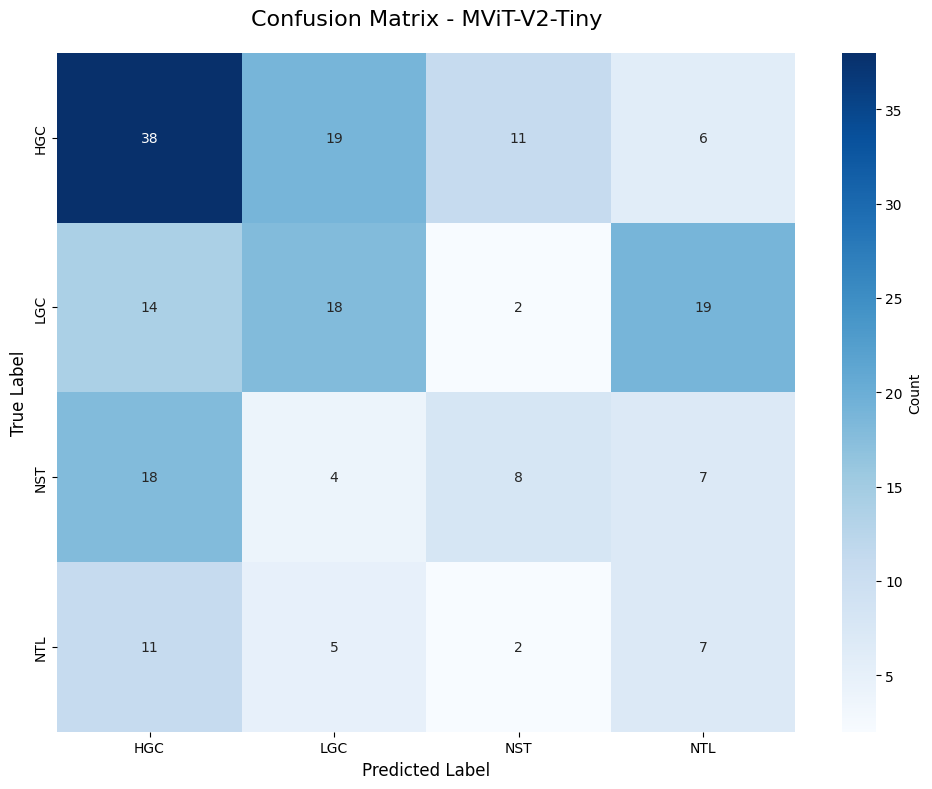

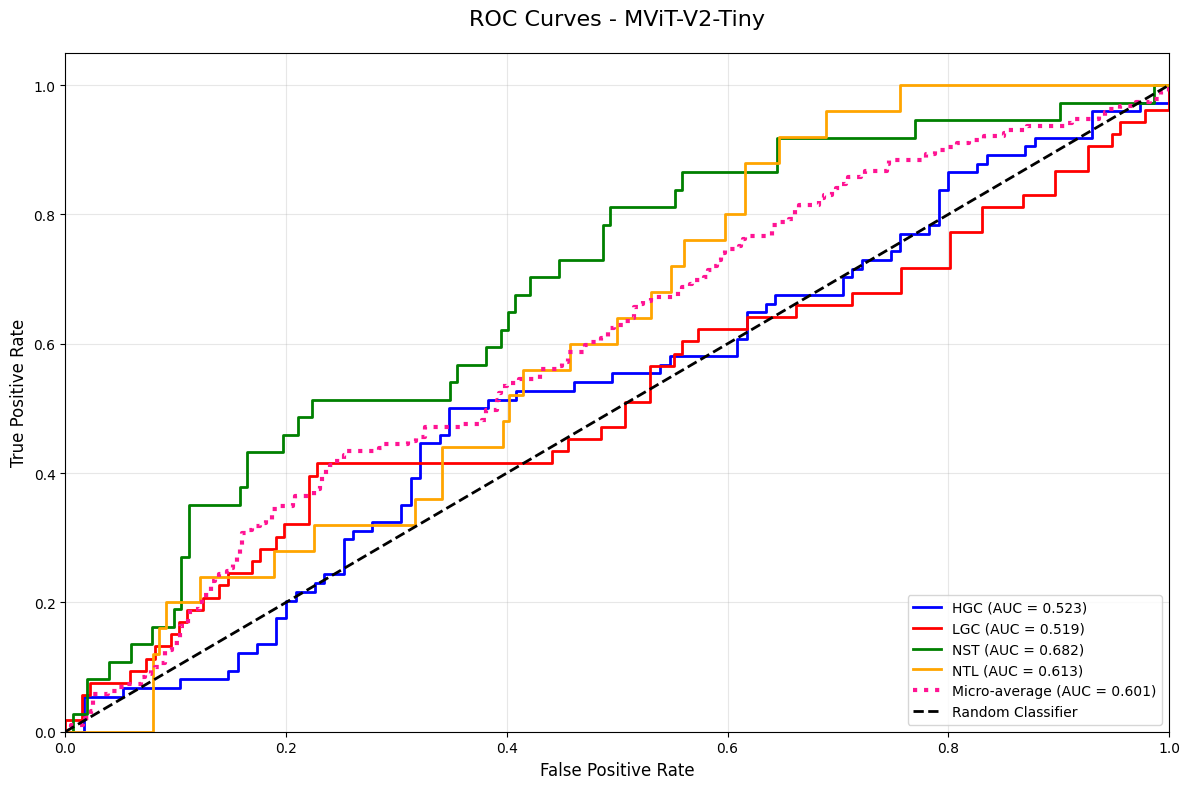


MViT v2 Tiny training and evaluation complete!


In [16]:
print("=" * 80)
print("Training MViT v2 Tiny (without Imaging Type)")
print("=" * 80)

# Create model
mvit_tiny = create_mvit_model(architecture='mvitv2_tiny', num_classes=4, pretrained=True)

# Create trainer
trainer_mvit_tiny = ModelTrainer(mvit_tiny, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_mvit_tiny = trainer_mvit_tiny.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="MViT-V2-Tiny")

# Plot training history
trainer_mvit_tiny.plot_training_history(save_path='mvit_v2_tiny_training_history.png')

# Evaluate model
results_mvit_tiny = trainer_mvit_tiny.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_mvit_tiny['confusion_matrix'], class_names, 'MViT-V2-Tiny',
                      save_path='mvit_v2_tiny_confusion_matrix.png')

# Plot ROC curves
roc_auc_mvit_tiny = plot_roc_curves(results_mvit_tiny['labels'], results_mvit_tiny['probabilities'], class_names, 'MViT-V2-Tiny',
                                     save_path='mvit_v2_tiny_roc_curves.png')

# Store results
results_mvit_tiny['model_name'] = 'MViT-V2-Tiny'
results_mvit_tiny['roc_auc'] = roc_auc_mvit_tiny
all_results.append(results_mvit_tiny)

print("\nMViT v2 Tiny training and evaluation complete!")

## Train MViT v2 Base

Training MViT v2 Base (without Imaging Type)


model.safetensors:   0%|          | 0.00/206M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.39it/s, Loss=1.4180, Acc=0.2072]


Train Loss: 1.4180 Acc: 0.2072 Macro-F1: 0.1971


Val : 100%|██████████| 10/10 [00:02<00:00,  3.76it/s, Loss=1.3843, Acc=0.2763]


Val Loss: 1.3843 Acc: 0.2763 Macro-F1: 0.1082
✓ New best model saved with validation macro-F1: 0.1082

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=1.4120, Acc=0.2558]


Train Loss: 1.4120 Acc: 0.2558 Macro-F1: 0.2245


Val : 100%|██████████| 10/10 [00:02<00:00,  3.81it/s, Loss=1.3568, Acc=0.2829]


Val Loss: 1.3568 Acc: 0.2829 Macro-F1: 0.1103
✓ New best model saved with validation macro-F1: 0.1103

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=1.3980, Acc=0.2508]


Train Loss: 1.3980 Acc: 0.2508 Macro-F1: 0.2123


Val : 100%|██████████| 10/10 [00:02<00:00,  3.78it/s, Loss=1.3707, Acc=0.3553]


Val Loss: 1.3707 Acc: 0.3553 Macro-F1: 0.2004
✓ New best model saved with validation macro-F1: 0.2004

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=1.4002, Acc=0.3742]


Train Loss: 1.4002 Acc: 0.3742 Macro-F1: 0.3203


Val : 100%|██████████| 10/10 [00:02<00:00,  3.77it/s, Loss=1.3913, Acc=0.3553]


Val Loss: 1.3913 Acc: 0.3553 Macro-F1: 0.1951

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=1.4027, Acc=0.2475]


Train Loss: 1.4027 Acc: 0.2475 Macro-F1: 0.2379


Val : 100%|██████████| 10/10 [00:02<00:00,  3.73it/s, Loss=1.3391, Acc=0.3684]


Val Loss: 1.3391 Acc: 0.3684 Macro-F1: 0.1346

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=1.3984, Acc=0.2212]


Train Loss: 1.3984 Acc: 0.2212 Macro-F1: 0.2069


Val : 100%|██████████| 10/10 [00:02<00:00,  3.81it/s, Loss=1.4097, Acc=0.0724]


Val Loss: 1.4097 Acc: 0.0724 Macro-F1: 0.0337

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=1.3934, Acc=0.2788]


Train Loss: 1.3934 Acc: 0.2788 Macro-F1: 0.2253


Val : 100%|██████████| 10/10 [00:02<00:00,  3.79it/s, Loss=1.3789, Acc=0.2763]


Val Loss: 1.3789 Acc: 0.2763 Macro-F1: 0.1082

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.40it/s, Loss=1.3858, Acc=0.2368]


Train Loss: 1.3858 Acc: 0.2368 Macro-F1: 0.1518


Val : 100%|██████████| 10/10 [00:02<00:00,  3.80it/s, Loss=1.3769, Acc=0.2829]


Val Loss: 1.3769 Acc: 0.2829 Macro-F1: 0.1103
Early stopping triggered after 8 epochs
Training complete in 3m 60s
Best validation macro-F1: 0.2004


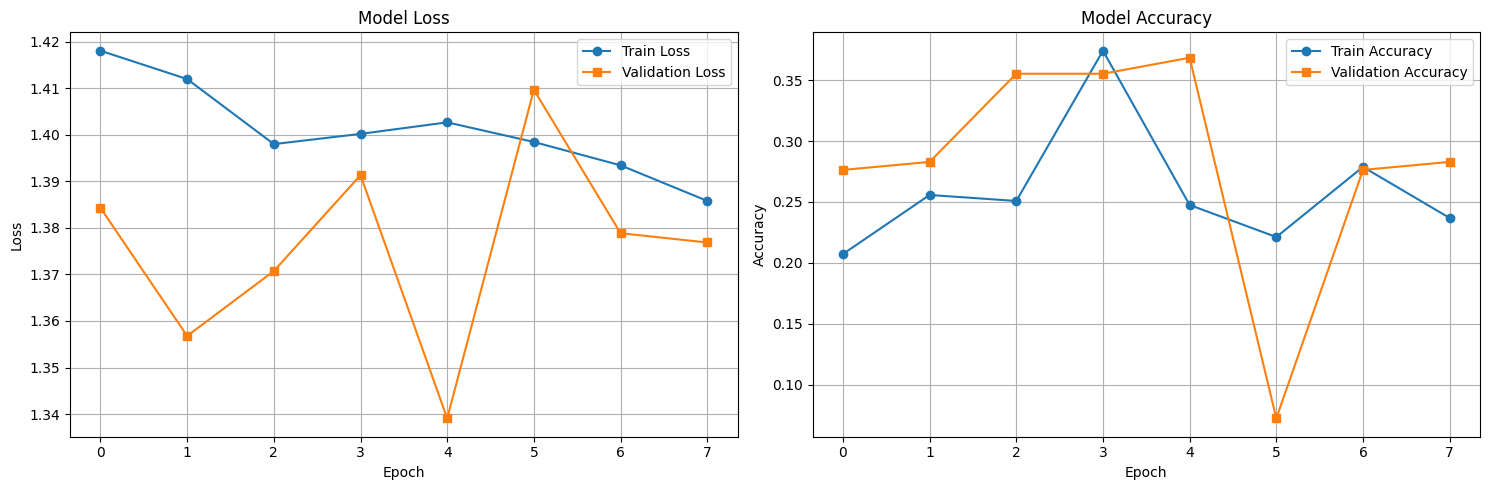

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.31it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/us

Test Accuracy: 39.15%
Test Loss: 1.3669

Classification Report:
              precision    recall  f1-score   support

         HGC       0.39      1.00      0.56        74
         LGC       0.00      0.00      0.00        53
         NST       0.00      0.00      0.00        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.39       189
   macro avg       0.10      0.25      0.14       189
weighted avg       0.15      0.39      0.22       189


Confusion Matrix:
[[74  0  0  0]
 [53  0  0  0]
 [37  0  0  0]
 [25  0  0  0]]

ROC-AUC Scores:
Macro-average AUC: 0.6273
Micro-average AUC: 0.6150
HGC AUC: 0.6699
LGC AUC: 0.7152
NST AUC: 0.6282
NTL AUC: 0.4961


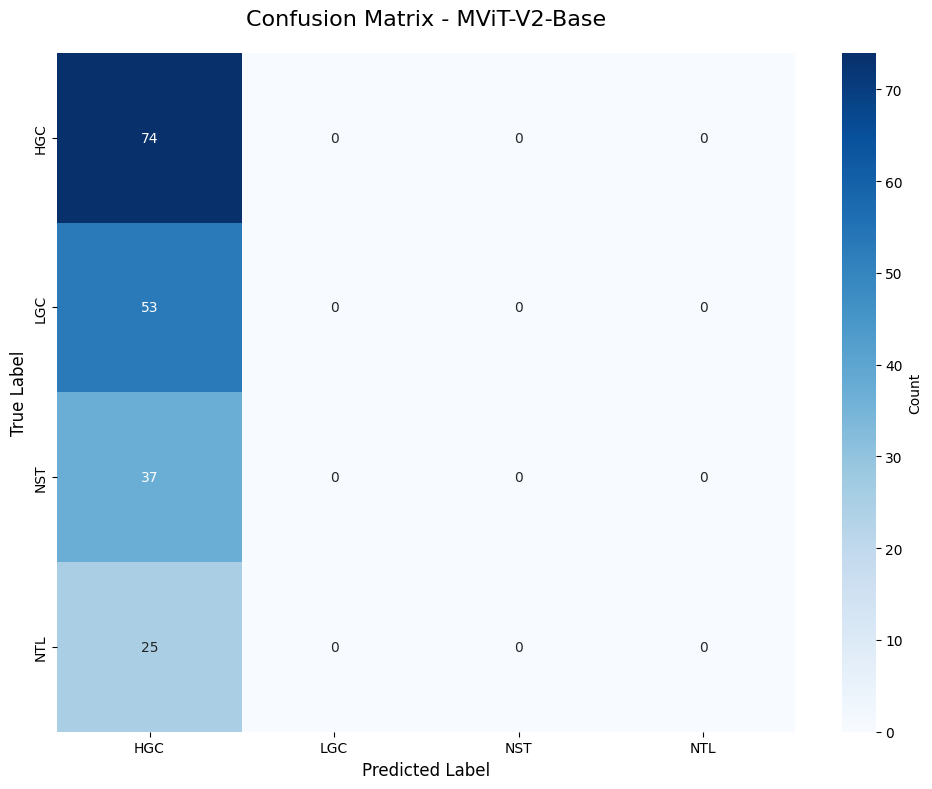

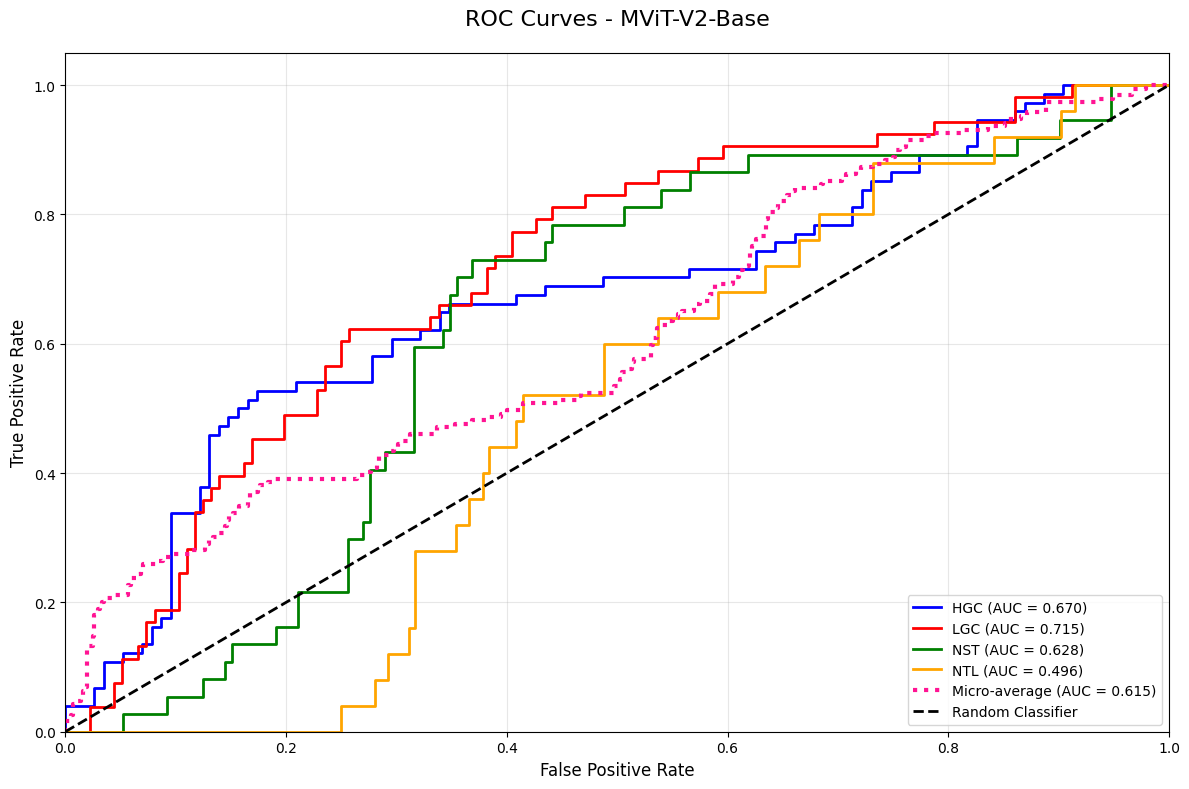


MViT v2 Base training and evaluation complete!


In [17]:
print("=" * 80)
print("Training MViT v2 Base (without Imaging Type)")
print("=" * 80)

# Create model
mvit_base = create_mvit_model(architecture='mvitv2_base', num_classes=4, pretrained=True)

# Create trainer
trainer_mvit_base = ModelTrainer(mvit_base, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_mvit_base = trainer_mvit_base.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="MViT-V2-Base")

# Plot training history
trainer_mvit_base.plot_training_history(save_path='mvit_v2_base_training_history.png')

# Evaluate model
results_mvit_base = trainer_mvit_base.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_mvit_base['confusion_matrix'], class_names, 'MViT-V2-Base',
                      save_path='mvit_v2_base_confusion_matrix.png')

# Plot ROC curves
roc_auc_mvit_base = plot_roc_curves(results_mvit_base['labels'], results_mvit_base['probabilities'], class_names, 'MViT-V2-Base',
                                     save_path='mvit_v2_base_roc_curves.png')

# Store results
results_mvit_base['model_name'] = 'MViT-V2-Base'
results_mvit_base['roc_auc'] = roc_auc_mvit_base
all_results.append(results_mvit_base)

print("\nMViT v2 Base training and evaluation complete!")

## Train MViT v2 Small

Training MViT v2 Small (without Imaging Type)


model.safetensors:   0%|          | 0.00/140M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.3984, Acc=0.3265]


Train Loss: 1.3984 Acc: 0.3265 Macro-F1: 0.2854


Val : 100%|██████████| 10/10 [00:02<00:00,  4.96it/s, Loss=1.4806, Acc=0.2928]


Val Loss: 1.4806 Acc: 0.2928 Macro-F1: 0.1284
✓ New best model saved with validation macro-F1: 0.1284

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.4084, Acc=0.2484]


Train Loss: 1.4084 Acc: 0.2484 Macro-F1: 0.2242


Val : 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, Loss=1.3957, Acc=0.3684]


Val Loss: 1.3957 Acc: 0.3684 Macro-F1: 0.1346
✓ New best model saved with validation macro-F1: 0.1346

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.3997, Acc=0.1801]


Train Loss: 1.3997 Acc: 0.1801 Macro-F1: 0.1692


Val : 100%|██████████| 10/10 [00:01<00:00,  5.01it/s, Loss=1.3923, Acc=0.2829]


Val Loss: 1.3923 Acc: 0.2829 Macro-F1: 0.1103

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.3960, Acc=0.3100]


Train Loss: 1.3960 Acc: 0.3100 Macro-F1: 0.2323


Val : 100%|██████████| 10/10 [00:02<00:00,  4.99it/s, Loss=1.3924, Acc=0.2763]


Val Loss: 1.3924 Acc: 0.2763 Macro-F1: 0.1082

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.4259, Acc=0.3396]


Train Loss: 1.4259 Acc: 0.3396 Macro-F1: 0.2509


Val : 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, Loss=1.3797, Acc=0.2763]


Val Loss: 1.3797 Acc: 0.2763 Macro-F1: 0.1082

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.3964, Acc=0.2599]


Train Loss: 1.3964 Acc: 0.2599 Macro-F1: 0.2401


Val : 100%|██████████| 10/10 [00:02<00:00,  4.97it/s, Loss=1.3709, Acc=0.2829]


Val Loss: 1.3709 Acc: 0.2829 Macro-F1: 0.1103

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.3828, Acc=0.3479]


Train Loss: 1.3828 Acc: 0.3479 Macro-F1: 0.2530


Val : 100%|██████████| 10/10 [00:02<00:00,  4.99it/s, Loss=1.4450, Acc=0.3882]


Val Loss: 1.4450 Acc: 0.3882 Macro-F1: 0.2421
✓ New best model saved with validation macro-F1: 0.2421

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.2910, Acc=0.4145]


Train Loss: 1.2910 Acc: 0.4145 Macro-F1: 0.2682


Val : 100%|██████████| 10/10 [00:02<00:00,  4.89it/s, Loss=1.1469, Acc=0.4737]


Val Loss: 1.1469 Acc: 0.4737 Macro-F1: 0.3083
✓ New best model saved with validation macro-F1: 0.3083

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.2435, Acc=0.4309]


Train Loss: 1.2435 Acc: 0.4309 Macro-F1: 0.3245


Val : 100%|██████████| 10/10 [00:02<00:00,  4.98it/s, Loss=1.2453, Acc=0.4046]


Val Loss: 1.2453 Acc: 0.4046 Macro-F1: 0.2589

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.1861, Acc=0.4581]


Train Loss: 1.1861 Acc: 0.4581 Macro-F1: 0.3353


Val : 100%|██████████| 10/10 [00:01<00:00,  5.00it/s, Loss=1.1969, Acc=0.4836]


Val Loss: 1.1969 Acc: 0.4836 Macro-F1: 0.2949

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.1784, Acc=0.4794]


Train Loss: 1.1784 Acc: 0.4794 Macro-F1: 0.3744


Val : 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, Loss=1.1591, Acc=0.4605]


Val Loss: 1.1591 Acc: 0.4605 Macro-F1: 0.3131
✓ New best model saved with validation macro-F1: 0.3131

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.1333, Acc=0.5115]


Train Loss: 1.1333 Acc: 0.5115 Macro-F1: 0.4173


Val : 100%|██████████| 10/10 [00:02<00:00,  4.95it/s, Loss=1.1066, Acc=0.5362]


Val Loss: 1.1066 Acc: 0.5362 Macro-F1: 0.3983
✓ New best model saved with validation macro-F1: 0.3983

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.1289, Acc=0.4860]


Train Loss: 1.1289 Acc: 0.4860 Macro-F1: 0.3783


Val : 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, Loss=1.0556, Acc=0.5822]


Val Loss: 1.0556 Acc: 0.5822 Macro-F1: 0.4805
✓ New best model saved with validation macro-F1: 0.4805

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.1233, Acc=0.4803]


Train Loss: 1.1233 Acc: 0.4803 Macro-F1: 0.4026


Val : 100%|██████████| 10/10 [00:02<00:00,  5.00it/s, Loss=1.0826, Acc=0.4868]


Val Loss: 1.0826 Acc: 0.4868 Macro-F1: 0.3904

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.98it/s, Loss=1.0842, Acc=0.5362]


Train Loss: 1.0842 Acc: 0.5362 Macro-F1: 0.4768


Val : 100%|██████████| 10/10 [00:02<00:00,  4.96it/s, Loss=1.0390, Acc=0.5559]


Val Loss: 1.0390 Acc: 0.5559 Macro-F1: 0.4728

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.0696, Acc=0.5526]


Train Loss: 1.0696 Acc: 0.5526 Macro-F1: 0.4901


Val : 100%|██████████| 10/10 [00:01<00:00,  5.00it/s, Loss=1.0209, Acc=0.5822]


Val Loss: 1.0209 Acc: 0.5822 Macro-F1: 0.4914
✓ New best model saved with validation macro-F1: 0.4914

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.0623, Acc=0.5592]


Train Loss: 1.0623 Acc: 0.5592 Macro-F1: 0.5023


Val : 100%|██████████| 10/10 [00:01<00:00,  5.04it/s, Loss=1.0218, Acc=0.5822]


Val Loss: 1.0218 Acc: 0.5822 Macro-F1: 0.4976
✓ New best model saved with validation macro-F1: 0.4976

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.98it/s, Loss=1.0591, Acc=0.5526]


Train Loss: 1.0591 Acc: 0.5526 Macro-F1: 0.4872


Val : 100%|██████████| 10/10 [00:02<00:00,  4.99it/s, Loss=1.0027, Acc=0.6020]


Val Loss: 1.0027 Acc: 0.6020 Macro-F1: 0.5149
✓ New best model saved with validation macro-F1: 0.5149

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.0561, Acc=0.5477]


Train Loss: 1.0561 Acc: 0.5477 Macro-F1: 0.4910


Val : 100%|██████████| 10/10 [00:01<00:00,  5.01it/s, Loss=1.0034, Acc=0.5822]


Val Loss: 1.0034 Acc: 0.5822 Macro-F1: 0.5041

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.0393, Acc=0.5650]


Train Loss: 1.0393 Acc: 0.5650 Macro-F1: 0.5079


Val : 100%|██████████| 10/10 [00:01<00:00,  5.09it/s, Loss=0.9912, Acc=0.5987]


Val Loss: 0.9912 Acc: 0.5987 Macro-F1: 0.5203
✓ New best model saved with validation macro-F1: 0.5203

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.0330, Acc=0.5559]


Train Loss: 1.0330 Acc: 0.5559 Macro-F1: 0.5017


Val : 100%|██████████| 10/10 [00:01<00:00,  5.07it/s, Loss=0.9787, Acc=0.5822]


Val Loss: 0.9787 Acc: 0.5822 Macro-F1: 0.5076

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.0241, Acc=0.5748]


Train Loss: 1.0241 Acc: 0.5748 Macro-F1: 0.5248


Val : 100%|██████████| 10/10 [00:01<00:00,  5.03it/s, Loss=0.9783, Acc=0.5789]


Val Loss: 0.9783 Acc: 0.5789 Macro-F1: 0.5045

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.0206, Acc=0.5699]


Train Loss: 1.0206 Acc: 0.5699 Macro-F1: 0.5162


Val : 100%|██████████| 10/10 [00:02<00:00,  4.93it/s, Loss=0.9777, Acc=0.5822]


Val Loss: 0.9777 Acc: 0.5822 Macro-F1: 0.5075

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.0188, Acc=0.5699]


Train Loss: 1.0188 Acc: 0.5699 Macro-F1: 0.5164


Val : 100%|██████████| 10/10 [00:01<00:00,  5.03it/s, Loss=0.9772, Acc=0.5822]


Val Loss: 0.9772 Acc: 0.5822 Macro-F1: 0.5071

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, Loss=1.0129, Acc=0.5732]


Train Loss: 1.0129 Acc: 0.5732 Macro-F1: 0.5236


Val : 100%|██████████| 10/10 [00:01<00:00,  5.14it/s, Loss=0.9756, Acc=0.5822]


Val Loss: 0.9756 Acc: 0.5822 Macro-F1: 0.5076
Early stopping triggered after 25 epochs
Training complete in 8m 51s
Best validation macro-F1: 0.5203


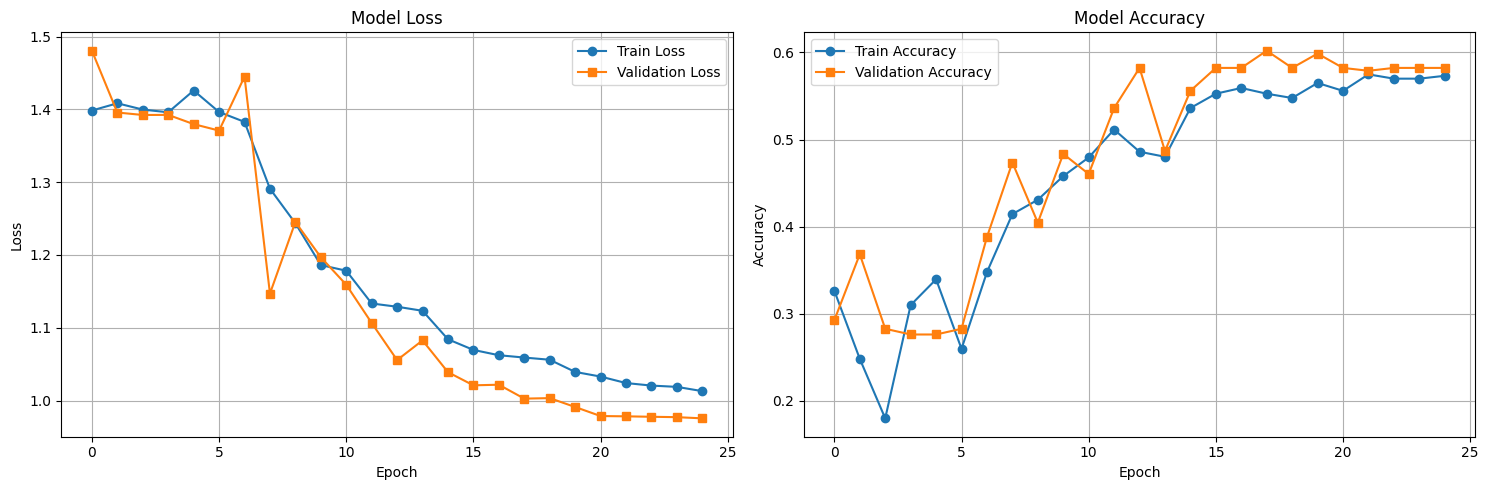

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.23it/s]


Test Accuracy: 23.28%
Test Loss: 1.4986

Classification Report:
              precision    recall  f1-score   support

         HGC       0.22      0.07      0.10        74
         LGC       0.00      0.00      0.00        53
         NST       0.26      0.59      0.36        37
         NTL       0.38      0.68      0.49        25

    accuracy                           0.23       189
   macro avg       0.21      0.34      0.24       189
weighted avg       0.19      0.23      0.17       189


Confusion Matrix:
[[ 5 35 28  6]
 [14  0 31  8]
 [ 1  0 22 14]
 [ 3  0  5 17]]

ROC-AUC Scores:
Macro-average AUC: 0.6096
Micro-average AUC: 0.5694
HGC AUC: 0.6470
LGC AUC: 0.3284
NST AUC: 0.6197
NTL AUC: 0.8434


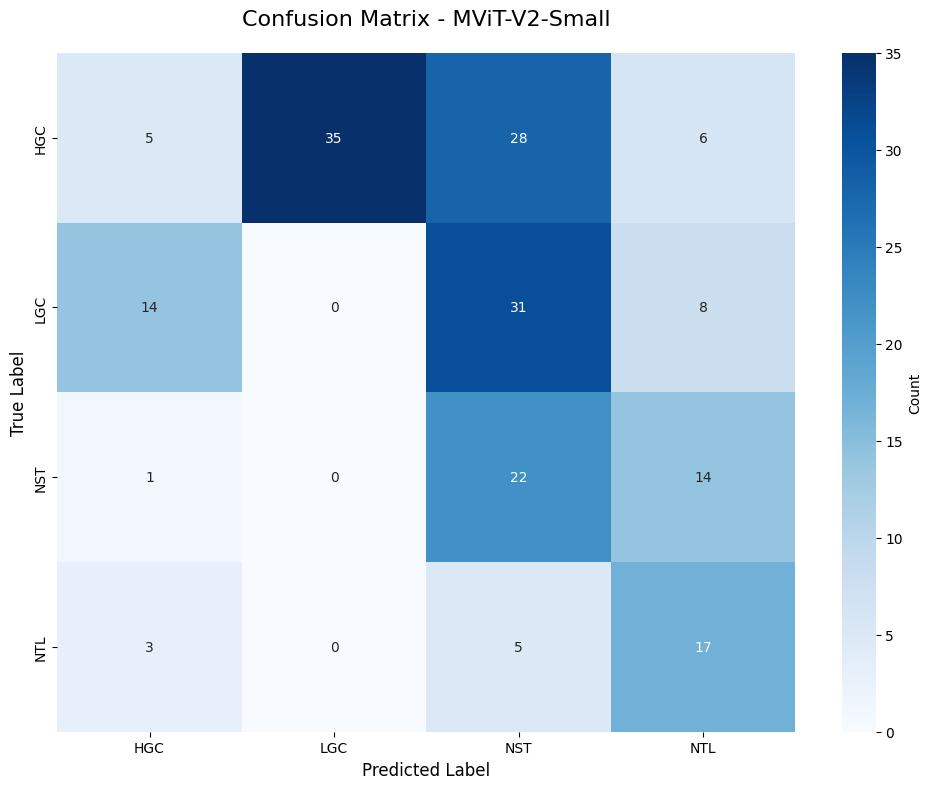

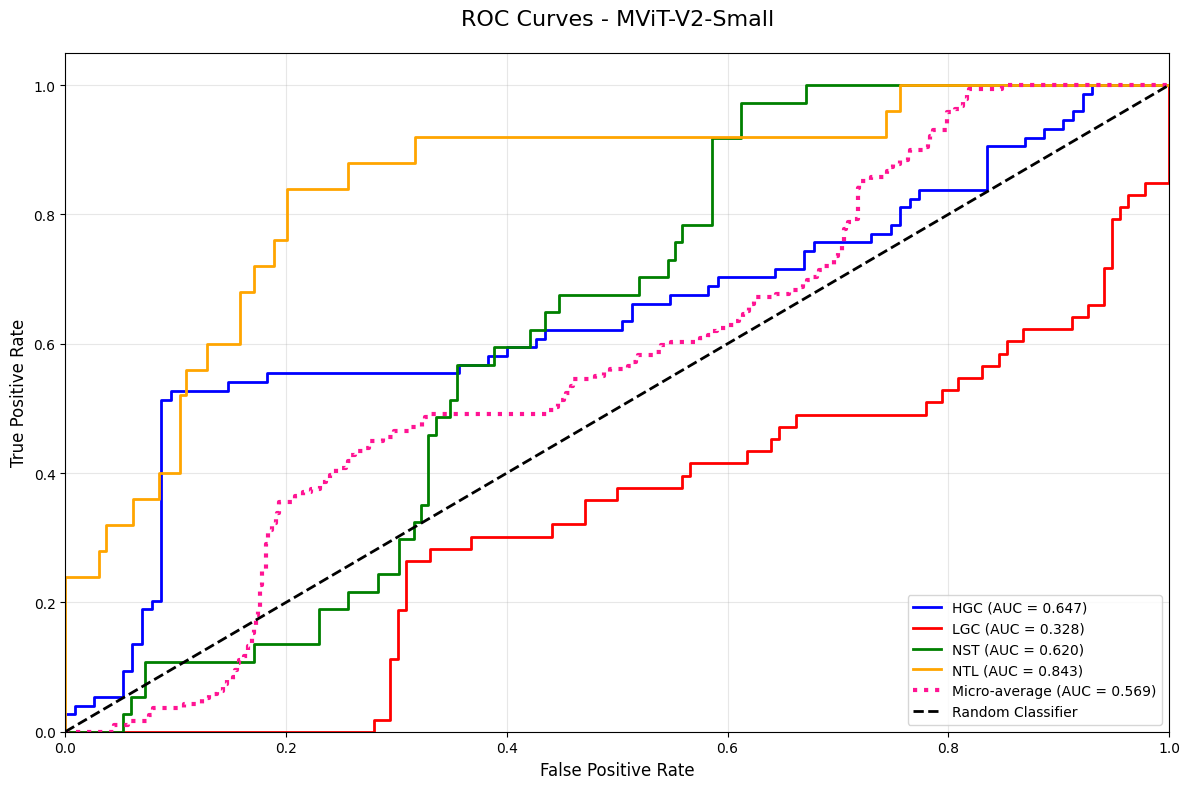


MViT v2 Small training and evaluation complete!


In [18]:
print("=" * 80)
print("Training MViT v2 Small (without Imaging Type)")
print("=" * 80)

# Create model
mvit_small = create_mvit_model(architecture='mvitv2_small', num_classes=4, pretrained=True)

# Create trainer
trainer_mvit_small = ModelTrainer(mvit_small, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_mvit_small = trainer_mvit_small.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="MViT-V2-Small")

# Plot training history
trainer_mvit_small.plot_training_history(save_path='mvit_v2_small_training_history.png')

# Evaluate model
results_mvit_small = trainer_mvit_small.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_mvit_small['confusion_matrix'], class_names, 'MViT-V2-Small',
                      save_path='mvit_v2_small_confusion_matrix.png')

# Plot ROC curves
roc_auc_mvit_small = plot_roc_curves(results_mvit_small['labels'], results_mvit_small['probabilities'], class_names, 'MViT-V2-Small',
                                     save_path='mvit_v2_small_roc_curves.png')

# Store results
results_mvit_small['model_name'] = 'MViT-V2-Small'
results_mvit_small['roc_auc'] = roc_auc_mvit_small
all_results.append(results_mvit_small)

print("\nMViT v2 Small training and evaluation complete!")

# Save All Metrics to CSV

In [19]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'MViT_V2_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: MViT_V2_metrics.csv

Metrics Summary:
           Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0   MViT-V2-Tiny         37.566138      2.452240             0.346938          0.337338      0.334844                0.385248             0.375661         0.375090       0.469136    0.513514  0.490323         74.0       0.391304    0.339623  0.363636         53.0       0.347826    0.216216  0.266667         37.0       0.179487        0.28  0.218750         25.0   0.584273   0.601411  0.523267  0.519423  0.681721  0.612683      0.523267  